# Act 1: Data-centric workflows

This notebook is Act 1 of 4 in the Building Multimodal AI Workflows with Pixeltable workshop.

**Notebook Segment**

In this act, we'll:
- Create a video table & insert media
- Add computations
- Write a query
- Detect scene boundaries in the video

**Documentation:** TODO

In [1]:
import pixeltable as pxt

### 01 - Create a video table & insert media

🖇️ Links to docs:

- Media types
- Tables
- Inserts


In [2]:
# TODO: delete this chunk
pxt.list_tables()
pxt.drop_table('chess_vids', force=True)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


We start by creating a fresh Pixeltable with a single column of type `pxt.Video`:

In [3]:
t = pxt.create_table(
    'chess_vids',
    schema={'video': pxt.Video},
    if_exists='replace_force'
)

Created table 'chess_vids'.


Of course, the table is empty to start, but the schema is there:

In [4]:
t

table 'chess_vids'

 Column Name   Type Computed With
       video  Video

We'll start with a single video and build up our video processing pipeline using this table:

In [5]:
t.insert([{'video': 'source/queens-gambit.mp4'}])

Inserting rows into `chess_vids`: 1 rows [00:00, 473.72 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

View the video we just inserted:

video
""

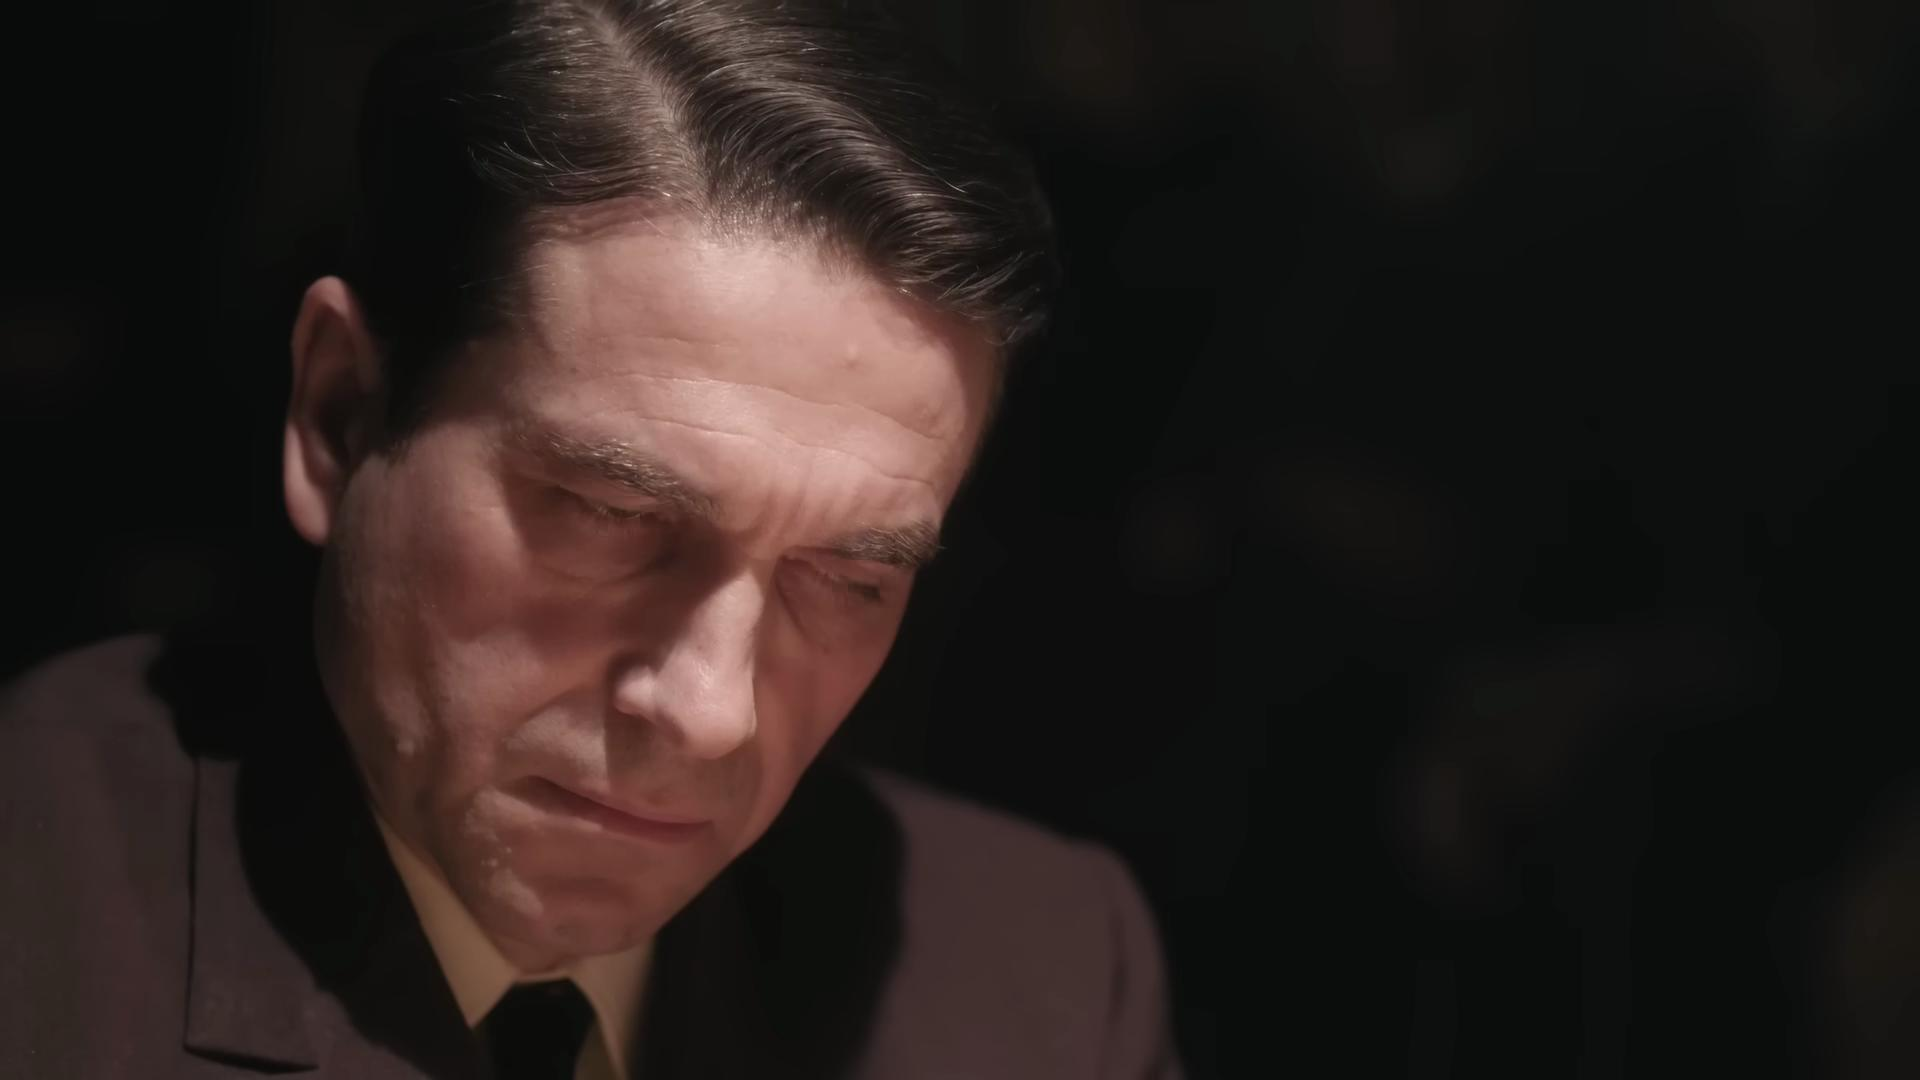

In [6]:
t.collect()

#### More to explore

More media types

More on tables and table operations

### 02 - Add computations

🖇️ Links to docs:

- Computed columns
- Metadata

We'll start with our first computed column. Here, we'll use a built-in Pixeltable function for getting the duration of a video file.

In [7]:
t.add_computed_column(duration=t.video.get_duration())

Added 1 column value with 0 errors.


1 row updated, 2 values computed.

We can check out the new table schema:

In [8]:
t

table 'chess_vids'

 Column Name   Type         Computed With
       video  Video                      
    duration  Float  video.get_duration()

And the new values in the table:

video,duration
,377.043

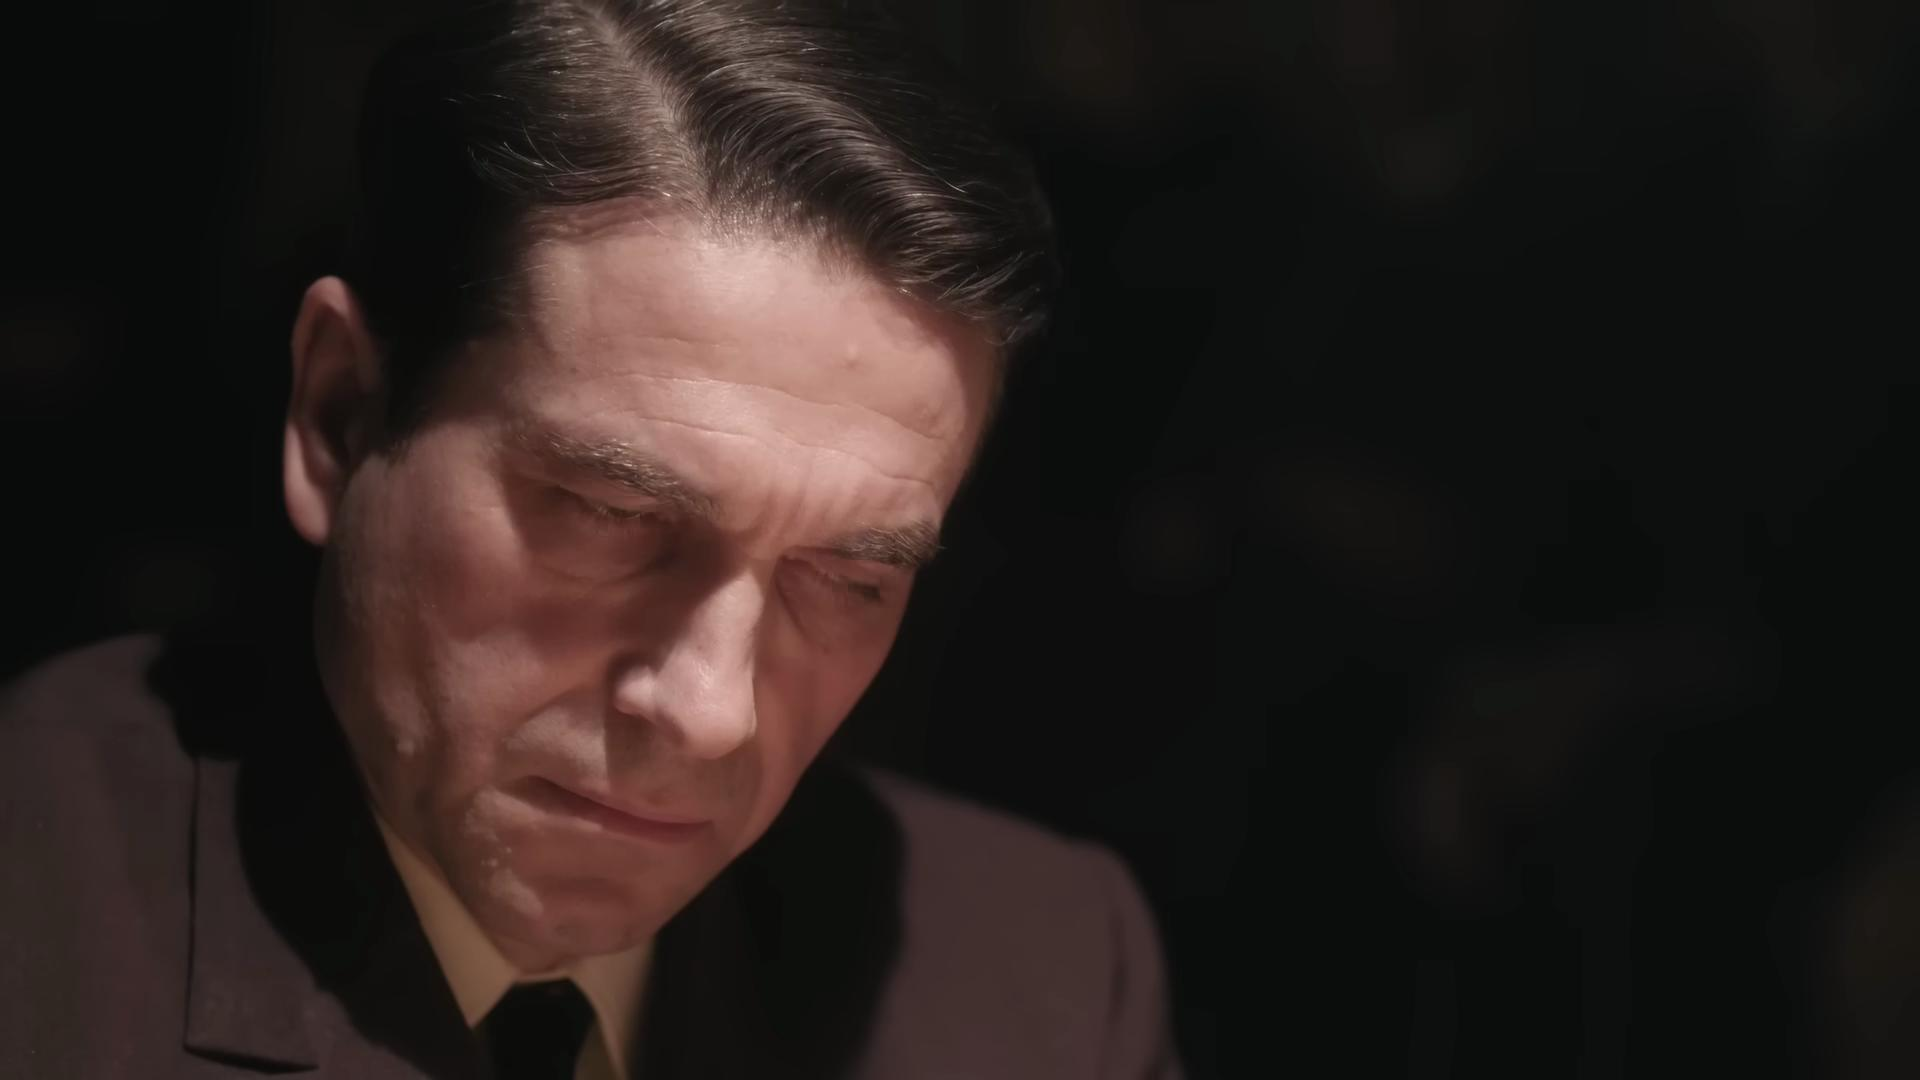

In [9]:
t.collect()

Now, we added that value as a computed column. This means a few things:
1. That value is now in our persistent storage - not just in memory for this Python session
2. For any new rows that are inserted, Pixeltable will compute the duration and fill in that cell
3. We can use that value in any future computations, and Pixeltable will orchestrate those to happen in the right sequence

#### More to explore

We just covered computed columns, learn more...

### 03 - Write a query

🖇️ Links to docs:

- Queries & expressions

But, let's say we don't want to commit a value to storage - we just want to explore and experiment. We can do that too, with queries using the `select()` and `collect()` combination in Pixeltable. Again, we'll use a built-in Pixletable function for videos to extract a single frame with a timestamp. Recall that our video was 377 seconds long, so you can re-run this cell over and over again to pull out any frame.

video,extract_frame
,

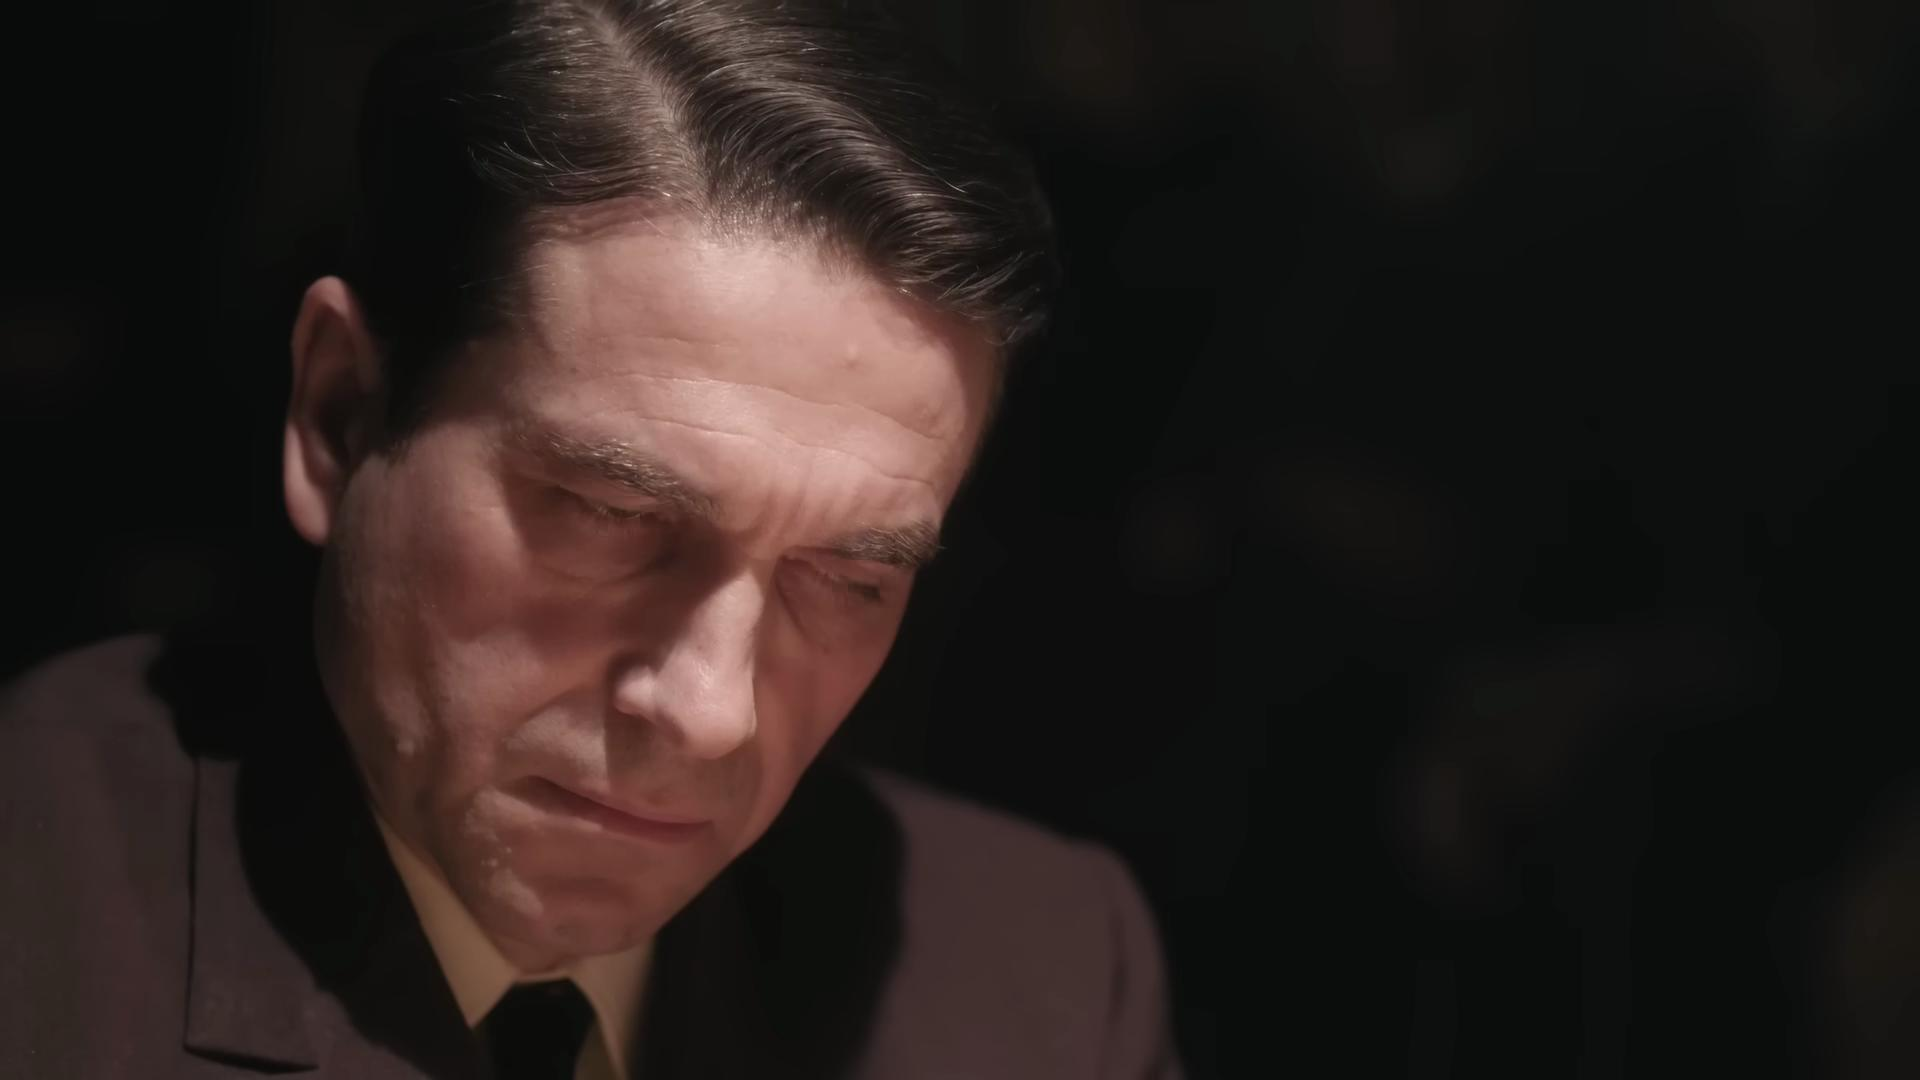
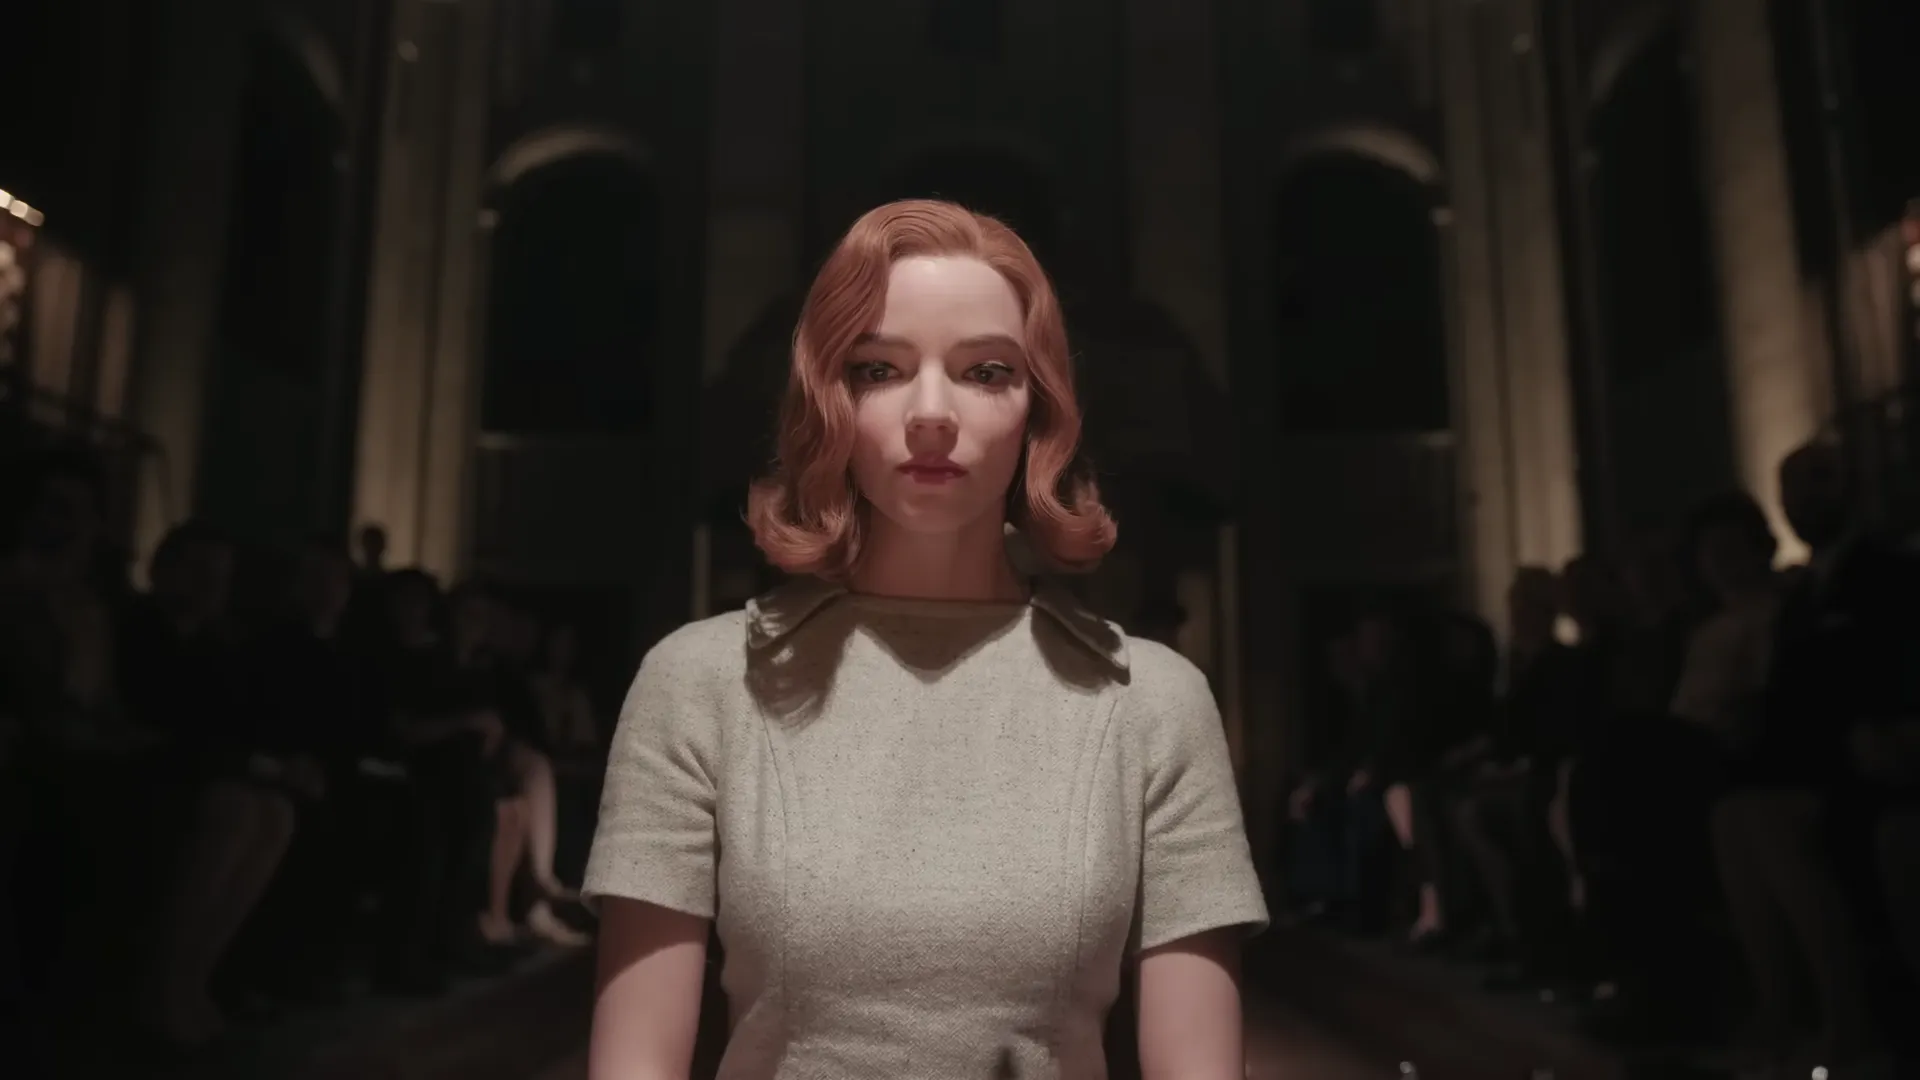

In [10]:
# use select() to query your table
# here, try changing the timestamp (between 0 and the duration of the video)
t.select(t.video, t.video.extract_frame(timestamp=75)).collect()

Let's take another look at our table schema. You should see that we have only added one new column here, since we extracted the frame inside a query. The "computed with" metadata is your clue that this is a value derived from the video input, and it is the start of using Pixeltable for orchestrating your media transformations.

In [11]:
t

table 'chess_vids'

 Column Name   Type         Computed With
       video  Video                      
    duration  Float  video.get_duration()

#### More to explore

What else is similar to `extract_frame()`

Video UDFs

### 04 - Scene detection

🖇️ Links to docs:

- Scene detection in Pixeltable
- PySceneDetect

Media data can be hard to work with because (a) files are big and (b) many of your normal tricks for slicing and dicing data with static values won't work reliably across media types and content. Best practices for working with media data start with content-aware transformations. 

We'll use Pixeltable's built-in integration with PySceneDetect for smart scene detection. It detects breaks in-between content, not only when the video fades to black (although a threshold mode is available as well for those cases). 

This cell takes about 1-2 minutes to run.

In [12]:
t.add_computed_column(
    scenes=t.video.scene_detect_content(fps=10),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

Because this is a computed column, the computations now persist in the table.

In [13]:
t

table 'chess_vids'

 Column Name   Type                       Computed With
       video  Video                                    
    duration  Float                video.get_duration()
      scenes   Json  video.scene_detect_content(fps=10)

Now we can view the output for the detected scenes, which is a single cell with a JSON structure.

In [14]:
t.select(t.scenes).collect()

scenes
"[{""duration"": 1.835, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 2.169, ""start_pts"": 44044, ""start_time"": 1.835}, {""duration"": 0.959, ""start_pts"": 96096, ""start_time"": 4.004}, {""duration"": 10.427, ""start_pts"": 119119, ""start_time"": 4.963}, {""duration"": 3.837, ""start_pts"": 369369, ""start_time"": 15.39}, {""duration"": 4.004, ""start_pts"": 461461, ""start_time"": 19.228}, ..., {""duration"": 2.502, ""start_pts"": 8263255, ""start_time"": 344.302}, {""duration"": 1.501, ""start_pts"": 8323315, ""start_time"": 346.805}, {""duration"": 2.127, ""start_pts"": 8359351, ""start_time"": 348.306}, {""duration"": 2.419, ""start_pts"": 8410402, ""start_time"": 350.433}, {""duration"": 2.336, ""start_pts"": 8468460, ""start_time"": 352.853}, {""duration"": 6.506, ""start_pts"": 8524516, ""start_time"": 355.188}]"


How can we examine the output from the scene detection model? The best way is to create a view on top of our video table. This view will then update any time the base table changes, keeping everything in sync as we work.

<aside>

### 🤿 **Technical Deep Dive** (5 min)

Persistent storage & why it matters for experimentation

- Database vs. in-memory processing
- Don't recompute expensive operations after kernel restart
- Demo: clear your notebook, restart kernel, and use `get_table()`
- *Links to: Database concepts docs*
</aside>


Trust us! Clear all your outputs, restart your kernels, then run this code:

In [15]:
del t

In [16]:
import pixeltable as pxt
pxt.list_tables()

['highlight_reels',
 'test_table',
 'reels',
 'chess_vids',
 'blob_storage_demo.media']

Any of these tables are "gettable" because Pixeltable persistently stores all of our outputs. So let's get the table we started with named `chess_vids` and assign it a variable `v` so we can pick up where we left off.

In [17]:
v = pxt.get_table('chess_vids')

Run a query and collect to see the contents. Luckily, we don't need to re-run scene detection in this new session because the output is stored in our table.

video,scenes
,"[{""duration"": 1.835, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 2.169, ""start_pts"": 44044, ""start_time"": 1.835}, {""duration"": 0.959, ""start_pts"": 96096, ""start_time"": 4.004}, {""duration"": 10.427, ""start_pts"": 119119, ""start_time"": 4.963}, {""duration"": 3.837, ""start_pts"": 369369, ""start_time"": 15.39}, {""duration"": 4.004, ""start_pts"": 461461, ""start_time"": 19.228}, ..., {""duration"": 2.502, ""start_pts"": 8263255, ""start_time"": 344.302}, {""duration"": 1.501, ""start_pts"": 8323315, ""start_time"": 346.805}, {""duration"": 2.127, ""start_pts"": 8359351, ""start_time"": 348.306}, {""duration"": 2.419, ""start_pts"": 8410402, ""start_time"": 350.433}, {""duration"": 2.336, ""start_pts"": 8468460, ""start_time"": 352.853}, {""duration"": 6.506, ""start_pts"": 8524516, ""start_time"": 355.188}]"

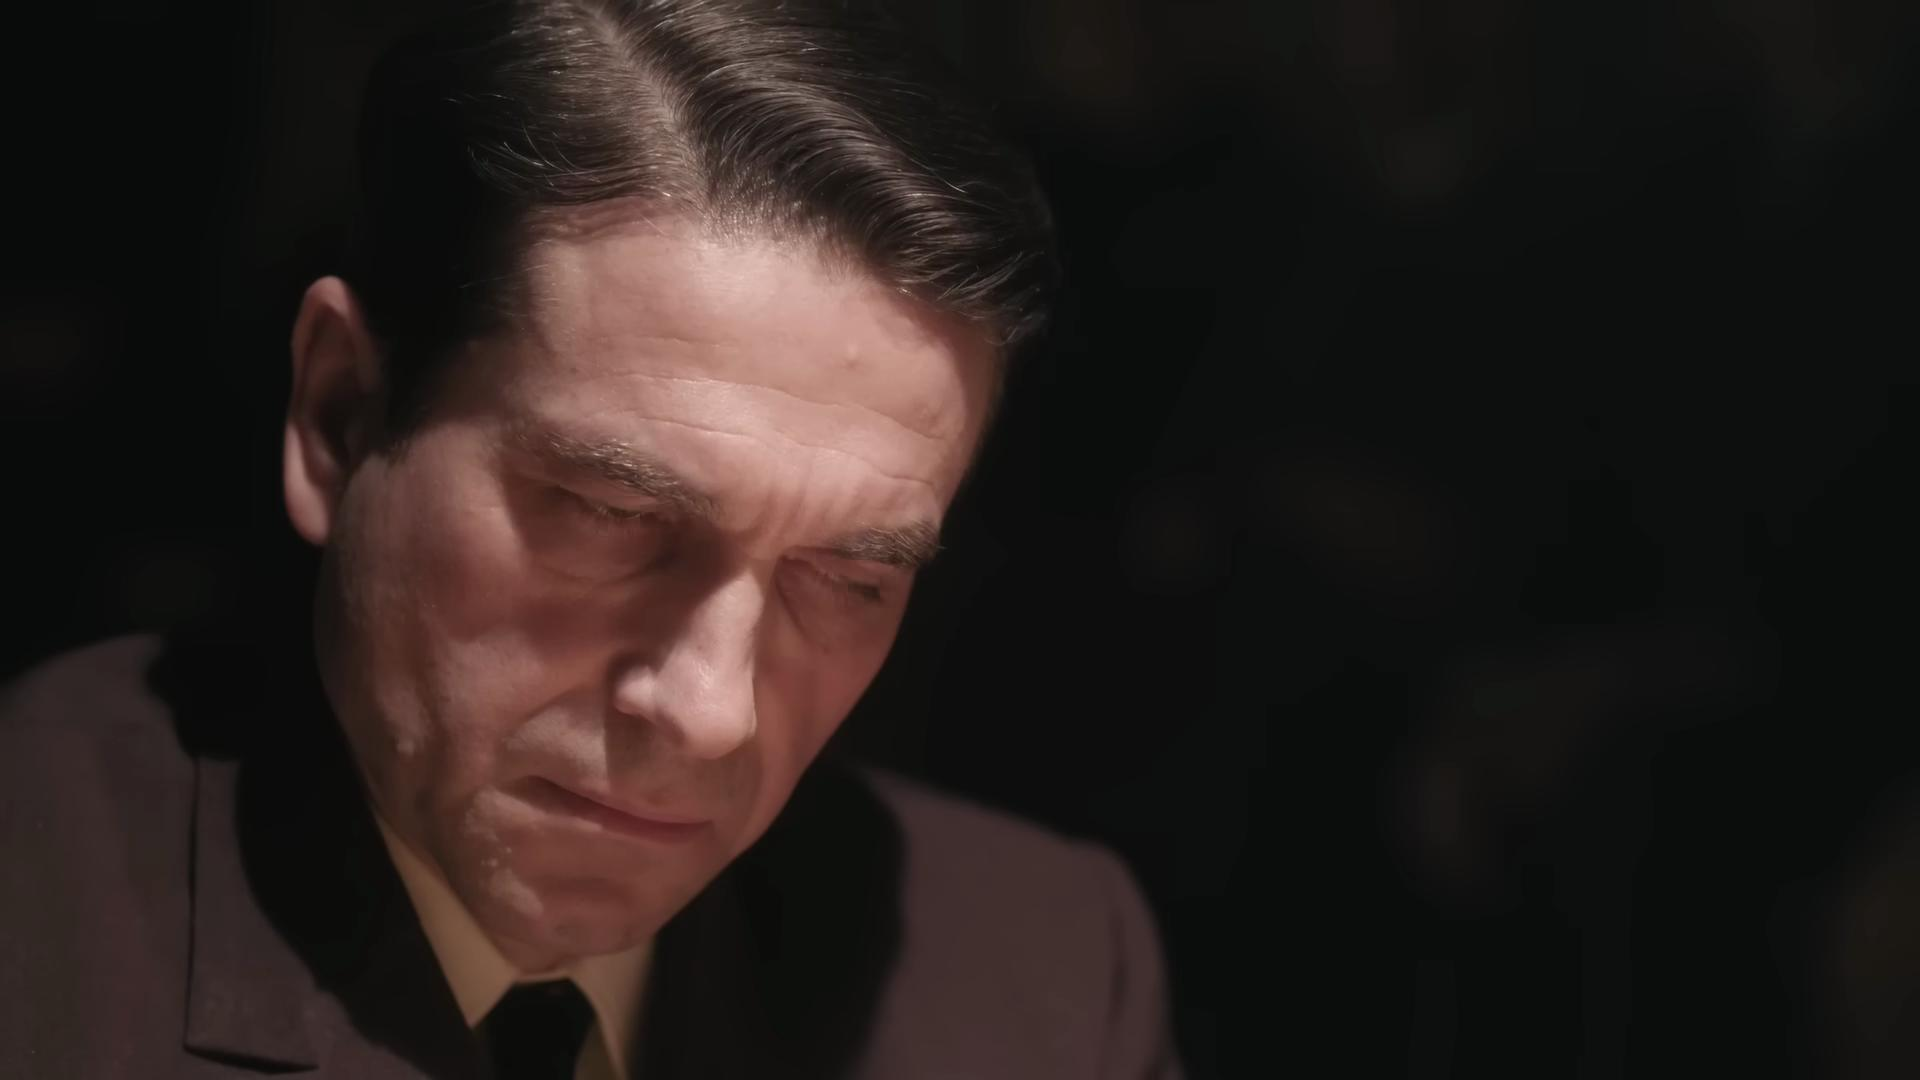

In [18]:
v.select(v.video, v.scenes).collect()